# All Modules Functionality Workbook

This notebook demonstrates all steps of the workflow: fetching, transforming, training, inference, and simulation.

In [1]:
import matplotlib.pyplot as plt
from scripts.data_repo import DataRepository
from scripts.transform import TransformData
from scripts.train import TrainModel
import warnings

In [2]:
# workflow settings
FETCH_REPO = False
TRANSFORM_DATA = False
TRAIN_MODEL = False

# 1) Fetching data from API / Loading from a local storage

In [3]:
repo = DataRepository()
if FETCH_REPO:
    # Fetch All 3 datasets for all dates from APIs
    repo.fetch()
    # save data to a local dir
    repo.persist(data_dir="local_data/")
else:
    # OR Load from disk
    repo.load(data_dir="local_data/")


# DEBUG: Separate fetching of the datasets (YFinance-Tickers, YFinance-Indexes, FRED-Macro)
# repo.fetch_indexes()
# repo.fetch_tickers()
# repo.fetch_macro()

In [4]:
repo.ticker_df.Date.agg({"min", "max", "count"})

max      2024-07-12
count        735098
min      1970-01-02
Name: Date, dtype: object

In [5]:
repo.ticker_df.Ticker.nunique()

87

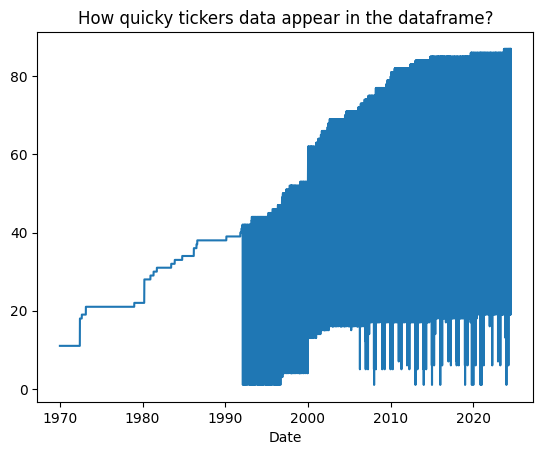

In [6]:
repo.ticker_df.groupby("Date")["Open"].agg("count").plot()
plt.title("How quicky tickers data appear in the dataframe?")
plt.show()

In [7]:
repo.indexes_df.shape

(13752, 49)

In [8]:
repo.indexes_df.tail(1)

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-12,1.005517,1.00688,1.019303,1.066148,1.094407,1.379503,1.011525,1.028076,1.020335,1.013528,...,0.985969,1.017105,1.026932,1.001531,1.00967,0.998108,1.021833,0.848453,0.90721,1.839477


In [9]:
repo.macro_df.tail(1)

,DGS1,DGS5,Date,Quarter,gdppot_us_yoy,gdppot_us_qoq,Month,FEDFUNDS,cpi_core_yoy,cpi_core_mom,DGS10
DATE,,,,,,,,,,,
2024-07-11,4.91,4.13,2024-07-11,2024-07-01,0.020675,0.005201,2024-07-01,5.33,0.032769,0.000648,4.2


# 2) Transform all input fields (data_repo dfs) to one dataframe

In [10]:
transformed = TransformData(repo=repo)

if TRANSFORM_DATA:
    transformed.transform()
    transformed.persist(data_dir="local_data/")
else:
    transformed.load(data_dir="local_data/")

In [11]:
transformed.transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 487820 entries, 7582 to 13751
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns, UTC](1), datetime64[ns](2), float64(128), int32(65), int64(5), object(2)
memory usage: 638.3+ MB


In [12]:
transformed.transformed_df.tail(2)

,Open,High,Low,Close,Adj Close,Volume,ticker_type,Ticker,Year,Month_x,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
13750,166.300003,166.630005,164.779999,165.539993,165.539993,5831500.0,US,PG,2024,7,...,0.986143,1.014011,1.022142,0.985460,0.993115,1.011283,1.006445,0.851674,0.853399,1.886864
13751,166.220001,167.639999,166.020004,166.610001,166.610001,4682400.0,US,PG,2024,7,...,0.985969,1.017105,1.026932,1.001531,1.009670,0.998108,1.021833,0.848453,0.907210,1.839477


In [13]:
# last 3 days of the data
transformed.transformed_df.tail(3)["Date"]

13749   2024-07-10 00:00:00+00:00
13750   2024-07-11 00:00:00+00:00
13751   2024-07-12 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]

# 3) Train the best model 
* Model : Random Forest(max_depth=17, n_estimators=200)

In [14]:
# Suppress all warnings (not recommended in production unless necessary)
warnings.filterwarnings("ignore")

trained = TrainModel(transformed=transformed)

if TRAIN_MODEL:
    trained.prepare_dataframe()  # prepare dataframes
    trained.train_random_forest()  # train the model
    trained.persist(data_dir="local_data/")  # save the model to disk
else:
    trained.prepare_dataframe()  # prepare dataframes (incl. for inference)
    trained.load(data_dir="local_data/")

Prepare the dataframe: define feature sets, add dummies, temporal split


KeyboardInterrupt: 

In [ ]:
# resulting df
trained.df_full.tail(2)

# 4) Inference

In [ ]:
prediction_name = "pred_rf_best"
trained.make_inference(pred_name=prediction_name)

In [ ]:
trained.df_full

In [ ]:
COLUMNS = ["Adj Close", "Ticker", "Date", prediction_name, prediction_name + "_rank"]
trained.df_full[trained.df_full[f"{prediction_name}_rank"] == 1].sort_values(
    by="Date"
).tail(10)[COLUMNS]

In [ ]:
print(
    trained.df_full[trained.df_full[f"{prediction_name}_rank"] == 1]
    .sort_values(by="Date")
    .tail(10)[COLUMNS]
)

# 5) Simulation

In [ ]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT

def get_predictions_correctness(df: pd.DataFrame, to_predict:str):
  PREDICTIONS = [k for k in df.keys() if k.startswith('pred')]
  print(f'Prediction columns founded: {PREDICTIONS}')

  # add columns is_correct_
  for pred in PREDICTIONS:
    part1 = pred.split('_')[0] # first prefix before '_'
    df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[to_predict]).astype(int)

  # IS_CORRECT features set
  IS_CORRECT =  [k for k in df.keys() if k.startswith('is_correct_')]
  print(f'Created columns is_correct: {IS_CORRECT}')

  print('Precision on TEST set for each prediction:')
  # define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
  for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.split=='test') & (new_df[prediction_column]==1)
    print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
    print(new_df[filter][is_correct_column].value_counts())
    print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))
    print('---------')

  return PREDICTIONS, IS_CORRECT

new_df = trained.df_full
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict="is_positive_growth_5d_future")
PREDICTIONS

In [ ]:
# Calculate fin. result for ALL predictions (manual and produced by models)

sim1_results = [] # results in Array

# Iterate over all predictions
for pred in PREDICTIONS:
  print(f'Calculating sumulation for prediction {pred}:')
  print(f"    Count times of investment {len(new_df[(new_df.split=='test')&(new_df[pred]==1)])} out of {len(new_df[(new_df.split=='test')])} TEST records")

  # Prefix: e.g. pred1 or pred10
  pred_prefix= pred.split('_')[0]

  # Fin. result columns: define new records for EACH positive prediction
  new_df['sim1_gross_rev_'+pred_prefix] = new_df[pred] * 100 * (new_df['growth_future_5d']-1)
  new_df['sim1_fees_'+pred_prefix] = -new_df[pred] * 100 * 0.002
  new_df['sim1_net_rev_'+pred_prefix] = new_df['sim1_gross_rev_'+pred_prefix] + new_df['sim1_fees_'+pred_prefix]

  # calculate agg. results for each PREDICTION columns (pred) on TEST
  filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1) # filter records on TEST set, when current prediction is 1 (we invest $100 for 1 week ahead - 5 periods)
  sim1_count_investments = len(new_df[filter_test_and_positive_pred])
  sim1_gross_rev = new_df[filter_test_and_positive_pred]['sim1_gross_rev_'+pred_prefix].sum()
  sim1_fees = new_df[filter_test_and_positive_pred]['sim1_fees_'+pred_prefix].sum()
  sim1_net_rev = new_df[filter_test_and_positive_pred]['sim1_net_rev_'+pred_prefix].sum()

  if sim1_gross_rev>0:
    sim1_fees_percentage = -sim1_fees/sim1_gross_rev
  else:
    sim1_fees_percentage = None

  if sim1_count_investments>0:
    sim1_average_net_revenue = sim1_net_rev/sim1_count_investments
  else:
    sim1_average_net_revenue = None

  # APPROXIMATE CAPITAL REQUIRED and CAGR Calculation
  df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
  sim1_avg_investments_per_day = df_investments_count_daily[pred].mean()
  sim1_q75_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
  # df_investments_count_daily[pred].mean()
  sim1_capital = 100 * 5 * sim1_q75_investments_per_day # 5 days in a row with positive predictions
  # CAGR: average growth per year. E.g. if you have 1.5 return (50% growth in 4 years) --> (1.5)**(1/4) = 1.106 or 10.6% average
  sim1_CAGR = ((sim1_capital+sim1_net_rev)/sim1_capital)**(1/4)

  # append to DF
  sim1_results.append((pred,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR))


  # output for all predictions with some positive predictions
  if  sim1_count_investments>1:
    print(f"    Financial Result: \n {new_df[filter_test_and_positive_pred][['sim1_gross_rev_'+pred_prefix,'sim1_fees_'+pred_prefix,'sim1_net_rev_'+pred_prefix]].sum()}")
    print(f"        Count Investments in 4 years (on TEST): {sim1_count_investments}")
    print(f"        Gross Revenue: ${int(sim1_gross_rev)}")
    print(f"        Fees (0.2% for buy+sell): ${int(-sim1_fees)}")
    print(f"        Net Revenue: ${int(sim1_net_rev)}")
    print(f"        Fees are {int(-100.0*sim1_fees/sim1_gross_rev)} % from Gross Revenue")
    print(f"        Capital Required : ${int(sim1_capital)} (Vbegin)")
    print(f"        Final value (Vbegin + Net_revenue) : ${int(sim1_capital + sim1_net_rev)} (Vfinal)")

    print(f"        Average CAGR on TEST (4 years) : {np.round(sim1_CAGR,3)}, or {np.round(100.0*(sim1_CAGR-1),1)}% ")

    print(f"        Average daily stats: ")
    print(f"            Average net revenue per investment: ${np.round(sim1_net_rev/sim1_count_investments,2)} ")
    print(f"            Average investments per day: {int(np.round(sim1_avg_investments_per_day))} ")
    print(f"            Q75 investments per day: {int(np.round(sim1_q75_investments_per_day))} ")
    print('=============================================+')


# results in a DataFrame from an Array
columns_simulation = ['prediction', 'sim1_count_investments', 'sim1_gross_rev', 'sim1_fees', 'sim1_net_rev', 'sim1_fees_percentage','sim1_average_net_revenue','sim1_avg_investments_per_day','sim1_capital','sim1_CAGR']

df_sim1_results = pd.DataFrame(sim1_results,columns=columns_simulation)

# Create the scatter plot
fig = px.scatter(
    df_sim1_results.dropna(),
    x='sim1_avg_investments_per_day',
    y='sim1_CAGR',
    size='sim1_growth_capital_4y',  # Use the 'size' parameter for sim1_CAGR
    text='prediction',
    title='Compound Annual Growth vs. Time spent (Average investments per day)',
    labels={'sim1_capital': 'Initial Capital Requirement', 'growth_capital_4y': '4-Year Capital Growth'}
)

# Update the layout to improve readability of the annotations
fig.update_traces(textposition='top center')

# Show the plot
fig.show()